## <span style="color:grey; font-weight:bold;">Import Tools and Def Functions</span>

In [ ]:
import os
import tensorflow as tf
import warnings
import importlib

warnings.filterwarnings("ignore")
tf.config.run_functions_eagerly(True)

def_file = "/Users/porter/Desktop/01.Data Science/Porter - Project/05 - Advertising Challenge - Data Analysis"
os.chdir(def_file)
import Def_Model
importlib.reload(Def_Model)

from Def_Model import TestTrainSplit, GenerateFeatureAndDict, DataTransfer, CompileAndFitModel, PredictEvaluateModel

data_file = "/Users/porter/Desktop/01.Data Science/Porter - Project/05 - Advertising Challenge - Data Analysis/00_Data/First Feature Selected"
os.chdir(data_file)

x_train shape: (14661875, 25), y_train shape: (14661875, 1)
x_train shape: (3141830, 25), y_train shape: (3141830, 1)
x_test shape: (3141831, 25), y_test shape: (3141831, 1)
Feature Dictionary: 25, Total Feature: 6352686

--- Training Parameters ---

{'embedding_size': 9, 'dropout_fm': [0.2, 0.2], 'deep_layers': [128, 64, 32], 'dropout_deep': [0.36, 0.36, 0.36], 'deep_layer_activation': <function relu at 0x3064bcf40>, 'batch_size': 2048, 'learning_rate': 0.002, 'optimizer': 'adam', 'l2_reg': 5e-06, 'loss': 'binary_crossentropy', 'metrics': [<AUC name=auc>], 'epochs': 50, 'lr_strategy': 'exp_decay'}

--- Training with Best Params ---

Epoch 1/50
7160/7160 ━━━━━━━━━━━━━━━━━━━━ 1256s 175ms/step - auc: 0.7523 - loss: 0.5040 - val_auc: 0.7753 - val_loss: 0.4869
Epoch 2/50
7160/7160 ━━━━━━━━━━━━━━━━━━━━ 1261s 176ms/step - auc: 0.7776 - loss: 0.4860 - val_auc: 0.7796 - val_loss: 0.4821
Epoch 3/50
7160/7160 ━━━━━━━━━━━━━━━━━━━━ 1228s 172ms/step - auc: 0.7837 - loss: 0.4801 - val_auc: 0.7818 - 

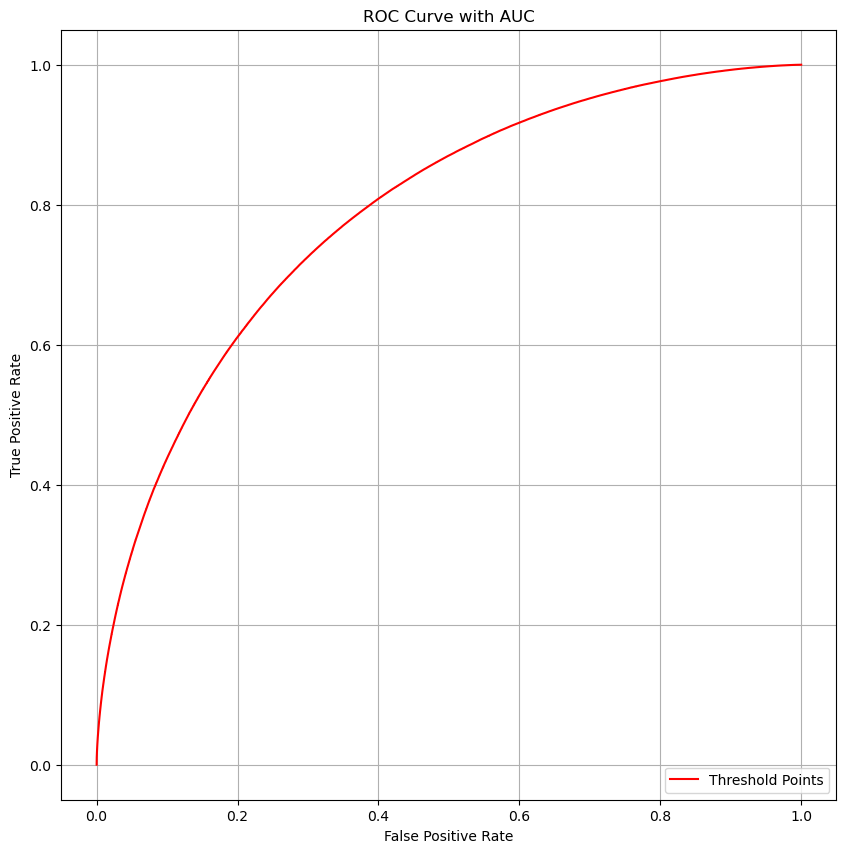

{'log loss': 0.455,
 'roc auc': 0.787,
 'precision': 0.653,
 'accuracy': 0.79,
 'recall': 0.33,
 'f1 score': 0.438}

In [12]:
numeric_cols = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13"]

data_file = "Top70AllColumnsFeature.csv"

x_train, x_val, x_test, y_train, y_val, y_test = TestTrainSplit(
    data_file,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    sample_ratio=1
)

feature_dict, total_feature, label_encoders, scalers = GenerateFeatureAndDict(x_train, x_val, x_test, numeric_cols)

train_feature_index, train_feature_value = DataTransfer(
    x_train, feature_dict, numeric_cols, scalers
)
train_y = y_train["Predicted"].values

val_feature_index, val_feature_value = DataTransfer(
    x_val, feature_dict, numeric_cols, scalers
)
val_y = y_val["Predicted"].values

test_feature_index, test_feature_value = DataTransfer(
    x_test, feature_dict, numeric_cols, scalers
)
test_y = y_test["Predicted"].values

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_train shape: {x_val.shape}, y_train shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
print(f"Feature Dictionary: {len(feature_dict)}, Total Feature: {total_feature}\n")

params = {
    "embedding_size":9,
    "dropout_fm":[0.2, 0.2],
    "deep_layers":[128, 64, 32],
    "dropout_deep":[0.36, 0.36, 0.36],
    "deep_layer_activation":tf.nn.relu,
    "batch_size":2048,
    "learning_rate":0.002,
    "optimizer":"adam",
    "l2_reg":0.000005,
    "loss":'binary_crossentropy',
    "metrics":[tf.keras.metrics.AUC(name="auc")],
    "epochs":50,
    "lr_strategy": "exp_decay"
}

feature_size = total_feature
field_size = train_feature_index.shape[1]

print("--- Training Parameters ---\n")
print(params)

print("\n--- Training with Best Params ---\n")
best_model, histories = CompileAndFitModel(
    train_feature_index, train_feature_value, train_y,
    val_feature_index, val_feature_value, val_y,
    params, feature_size, earlystopping_patience=3,
    reduce_factor=0.9, reduce_patience=1, min_lr=1e-7,
    decay_steps=2000, decay_rate=0.94, n_split=0
)

print("\n--- Evaluating Best Model ---\n")
PredictEvaluateModel(best_model, test_feature_index, test_feature_value, test_y, threshold=0.5)

In [ ]:
keras.saving.save_model(best_model, "EnhanceOptunaBestParamsModel.keras")
print("Final model saved as EnhanceOptunaBestParamsModel.keras")

In [ ]:
test_file = "/Users/porter/Desktop/01.Data Science/Porter - Project/05 - Advertising Challenge - Data Analysis/00_Programming Version4/01_Data"
os.chdir(test_file)
test_data = pd.read_csv("TransferTestData.csv", sep=",")

joblib_file = "/Users/porter/Desktop/01.Data Science/Porter - Project/05 - Advertising Challenge - Data Analysis/00_Programming Version4/01_Data/First Feature Selected"
os.chdir(joblib_file)
feature_dict, scalers = joblib.load("feature_metadata.pkl")

feature_index, feature_value = DataTransfer(test_data, feature_dict, numeric_cols, scalers)
print(f"Index shape: {feature_index.shape}, Value shape: {feature_value.shape}")
print(f"Feature Dictionary: {len(feature_dict)}, Total Feature: {total_feature}")

prediction = best_model.predict([feature_index, feature_value])

predictions = np.array(prediction).flatten()

assert len(predictions) == 6042134, f"Length Error"

submission = pd.DataFrame({
    "Id": range(60000000, 60000000 + len(predictions)),
    "Predicted": predictions
})

submission.to_csv("submission_20250214.csv", index=False, header=1, encoding="utf-8")